# The Autophase Testing Notebook

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

# Assuming xmris is installed or in your path and accessors are registered
from xmris.fitting.simulation import simulate_fid

# =============================================================================
# Universal Plotting Function
# =============================================================================
def plot_spectra(spectra_list, title, target_coord=None, peak_width=None):
    """
    Dynamically plots an arbitrary number of spectra for visual inspection.

    Parameters
    ----------
    spectra_list : list of tuples
        List containing (xr.DataArray, "Label String") pairs.
    title : str
        The main title for the figure.
    target_coord : float, optional
        The center coordinate of the ROI to highlight.
    peak_width : float, optional
        The width of the ROI to highlight.
    """
    n_plots = len(spectra_list)
    # Dynamically scale figure height based on the number of subplots
    fig, axes = plt.subplots(n_plots, 1, figsize=(10, 2.2 * n_plots), sharex=True)

    # Handle the edge case where only one spectrum is passed
    if n_plots == 1:
        axes = [axes]

    fig.suptitle(title, fontsize=14, fontweight="bold")

    for ax, (da, label) in zip(axes, spectra_list):
        # Style the explicitly 'Corrected' ground truth differently for visibility
        if "Corrected" in label:
            ax.plot(da.coords["chemical_shift"], np.real(da.values), color="blue", lw=2)
        else:
            ax.plot(da.coords["chemical_shift"], np.real(da.values), color="black", lw=1.2)

        ax.set_ylabel("Amplitude")
        ax.legend([label], loc="upper right")
        ax.grid(True, alpha=0.3)
        ax.axhline(0, color="red", linestyle="--", alpha=0.5)

        # Highlight the exact target ROI if provided
        if target_coord is not None and peak_width is not None:
            roi_start = target_coord + (peak_width / 2.0)
            roi_end = target_coord - (peak_width / 2.0)
            ax.axvspan(roi_start, roi_end, color='green', alpha=0.1)

    axes[-1].set_xlabel("Chemical Shift (ppm)")
    axes[-1].invert_xaxis()  # Standard NMR convention
    plt.tight_layout()
    plt.show()


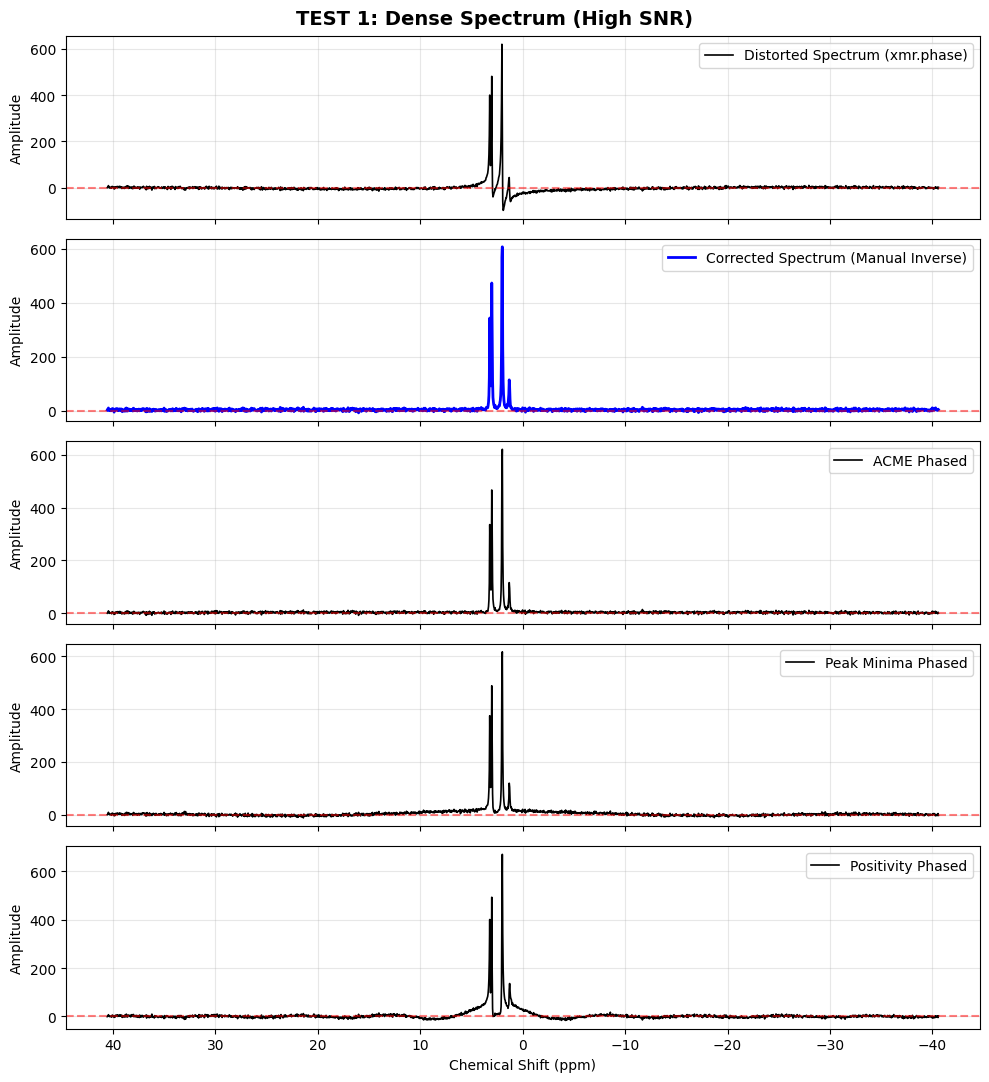

In [3]:
# =============================================================================
# TEST 1: Complex Multi-Peak Spectrum (ACME Territory)
# =============================================================================
# 1. Simulate an ideal, perfectly phased FID
fid_ideal = simulate_fid(
    amplitudes=[100, 60, 40, 20], chemical_shifts=[2.0, 3.0, 3.2, 1.3],
    reference_frequency=123.2, carrier_ppm=0.0, dampings=[30, 25, 25, 40],
    dead_time=0.0, phases=0.0, target_snr=50, n_points=2048
)
spec_ideal = fid_ideal.xmr.to_spectrum().xmr.to_ppm()

# 2. Distort it natively in the frequency domain
p0_distort = 60.0
p1_distort = -800.0
pivot_val = 0.0

spec_distorted = spec_ideal.xmr.phase(
    dim="chemical_shift", p0=p0_distort, p1=p1_distort, pivot=pivot_val
)

# 3. Apply manual correction (double apply with inverted signs)
spec_corrected = spec_distorted.xmr.phase(
    dim="chemical_shift", p0=-p0_distort, p1=-p1_distort, pivot=pivot_val
)

# 4. Run Autophasing on the distorted spectrum
acme_res = spec_distorted.xmr.autophase(method="acme", dim="chemical_shift")
pkmin_res = spec_distorted.xmr.autophase(method="peak_minima", peak_width=5.0, dim="chemical_shift")
posit_res = spec_distorted.xmr.autophase(method="positivity", peak_width=5.0, dim="chemical_shift")

# 5. Build the list of spectra and plot
spectra_to_plot = [
    (spec_distorted, "Distorted Spectrum (xmr.phase)"),
    (spec_corrected, "Corrected Spectrum (Manual Inverse)"),
    (acme_res, "ACME Phased"),
    (pkmin_res, "Peak Minima Phased"),
    (posit_res, "Positivity Phased")
]

plot_spectra(spectra_to_plot, "TEST 1: Dense Spectrum (High SNR)")


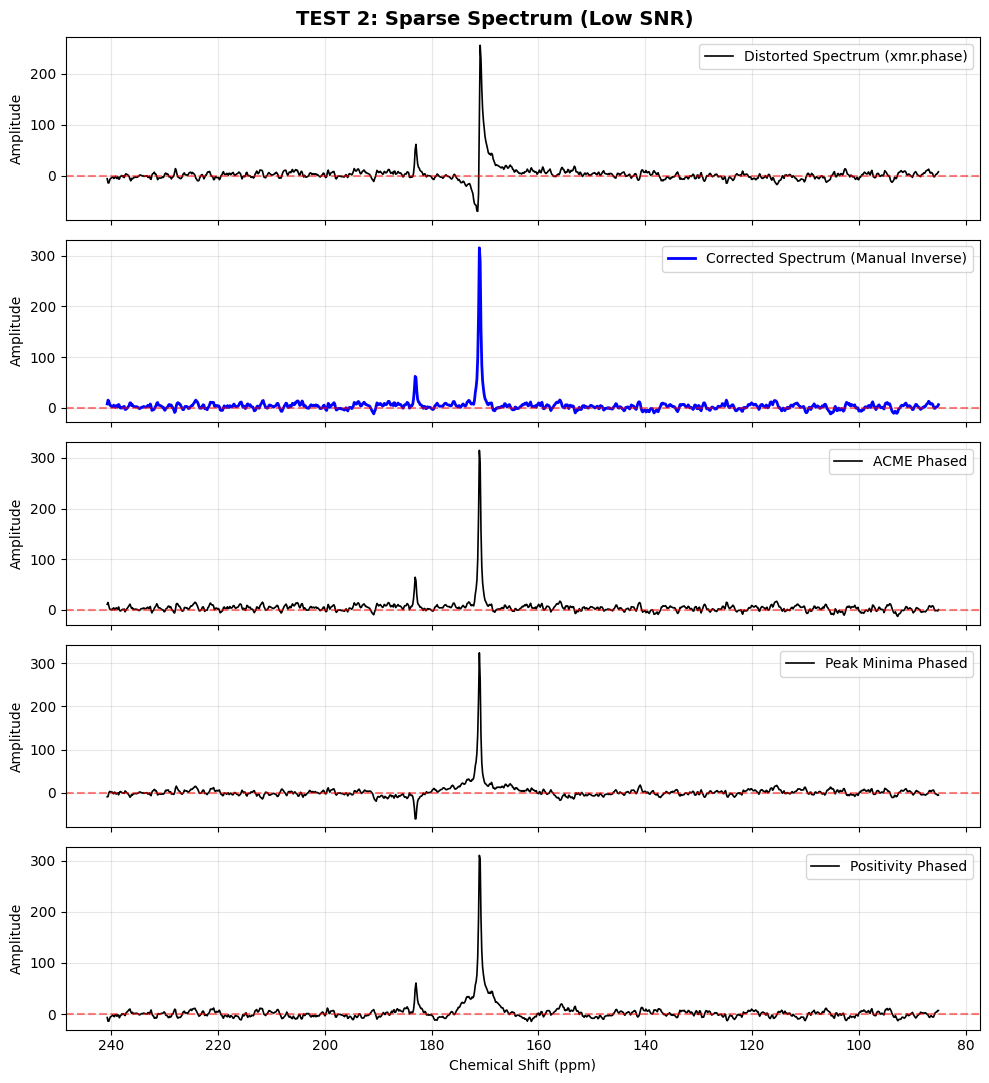

In [7]:
# =============================================================================
# TEST 2: Sparse, Noisy Spectrum (Positivity Territory)
# =============================================================================
# 1. Simulate an ideal, but NOISY FID
fid_noisy = simulate_fid(
    amplitudes=[100, 20], chemical_shifts=[171.0, 183.0],
    reference_frequency=32.1, carrier_ppm=163.0, spectral_width=5000,
    dampings=[15, 15], dead_time=0.0, phases=0.0, target_snr=4, n_points=1024
)
spec_noisy = fid_noisy.xmr.apodize_exp(lb=10.0).xmr.to_spectrum().xmr.to_ppm()

# 2. Distort it
p0_distort_s = -45.0
p1_distort_s = 500.0
pivot_s = 175.0

spec_distorted_s = spec_noisy.xmr.phase(
    dim="chemical_shift", p0=p0_distort_s, p1=p1_distort_s, pivot=pivot_s
)

# 3. Manual correction
spec_corrected_s = spec_distorted_s.xmr.phase(
    dim="chemical_shift", p0=-p0_distort_s, p1=-p1_distort_s, pivot=pivot_s
)

# 4. Autophase
acme_s = spec_distorted_s.xmr.autophase(dim="chemical_shift", method="acme")
pkmin_s = spec_distorted_s.xmr.autophase(dim="chemical_shift", method="peak_minima", peak_width=10.0)
posit_s = spec_distorted_s.xmr.autophase(dim="chemical_shift", method="positivity", peak_width=10.0)

spectra_to_plot_s = [
    (spec_distorted_s, "Distorted Spectrum (xmr.phase)"),
    (spec_corrected_s, "Corrected Spectrum (Manual Inverse)"),
    (acme_s, "ACME Phased"),
    (pkmin_s, "Peak Minima Phased"),
    (posit_s, "Positivity Phased")
]

plot_spectra(spectra_to_plot_s, "TEST 2: Sparse Spectrum (Low SNR)")


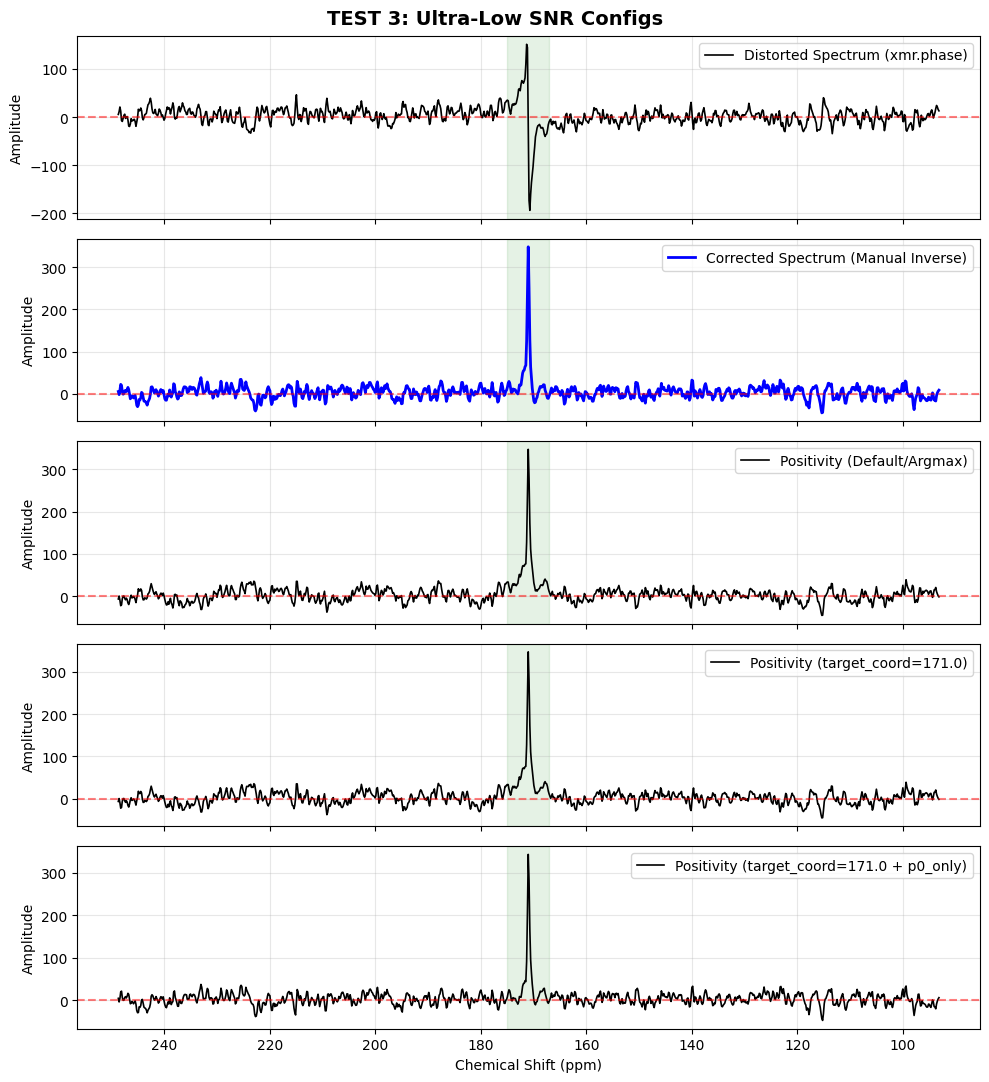

In [ ]:
# =============================================================================
# TEST 3: Ultra-Low SNR Configurations (target_coord & p0_only)
# =============================================================================
# 1. Simulate an ideal, ULTRA-NOISY FID
fid_ultra = simulate_fid(
    amplitudes=[100], chemical_shifts=[171.0],
    reference_frequency=32.1, carrier_ppm=171.0, spectral_width=5000,
    dampings=[15], dead_time=0.0, phases=0.0, target_snr=1.5, n_points=1024
)
spec_ultra = fid_ultra.xmr.apodize_exp(lb=10.0).xmr.to_spectrum().xmr.to_ppm()

# 2. Distort it (Heavy p0 twist, no p1 roll for this test)
p0_distort_u = 90.0
p1_distort_u = 0.0
pivot_u = 171.0

spec_distorted_u = spec_ultra.xmr.phase(
    dim="chemical_shift", p0=p0_distort_u, p1=p1_distort_u, pivot=pivot_u
)

# 3. Manual correction
spec_corrected_u = spec_distorted_u.xmr.phase(
    dim="chemical_shift", p0=-p0_distort_u, p1=-p1_distort_u, pivot=pivot_u
)

# 4. Autophase (Testing Positivity configurations)
target = 171.0
roi_width = 8.0

pos_def = spec_distorted_u.xmr.autophase(
    dim="chemical_shift", method="positivity", peak_width=roi_width
)
pos_tgt = spec_distorted_u.xmr.autophase(
    dim="chemical_shift", method="positivity", peak_width=roi_width, target_coord=target
)
pos_tgt_p0 = spec_distorted_u.xmr.autophase(
    dim="chemical_shift", method="positivity", peak_width=roi_width, target_coord=target, p0_only=True
)

# It's now trivial to pass exactly what we want to compare
spectra_to_plot_u = [
    (spec_distorted_u, "Distorted Spectrum (xmr.phase)"),
    (spec_corrected_u, "Corrected Spectrum (Manual Inverse)"),
    (pos_def, "Positivity (Default/Argmax)"),
    (pos_tgt, f"Positivity (target_coord={target})"),
    (pos_tgt_p0, f"Positivity (target_coord={target} + p0_only)")
]

plot_spectra(
    spectra_to_plot_u,
    "TEST 3: Ultra-Low SNR Configs",
    target_coord=target,
    peak_width=roi_width
)